In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_TSNE2_TSNE3.pth'


/home/guangwei/miniconda3/envs/sit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
from sklearn.manifold import TSNE
def extract_hidden_states(texts, model, tokenizer, apply_tsne=True, n_components=2, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_state = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
        hidden_states.append(hidden_state)

    hidden_states = np.vstack(hidden_states)
    if apply_tsne:
        tsne = TSNE(n_components=n_components, random_state=42)
        hidden_states = tsne.fit_transform(hidden_states)
        print(f"Hidden states reduced to {n_components} dimensions using t-SNE.")
        
    return hidden_states

def extract_reference_embeddings(references, model, tokenizer, apply_tsne=True, n_components=3, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())  # 提取池化后的输出

    embeddings = np.vstack(embeddings)
    
    # 应用 t-SNE
    if apply_tsne:
        tsne = TSNE(n_components=n_components, random_state=42)
        embeddings = tsne.fit_transform(embeddings)
        print(f"Reference embeddings reduced to {n_components} dimensions using t-SNE.")
    
    return embeddings

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]
/home/guangwei/miniconda3/envs/sit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 373/373 [01:44<00:00,  3.56it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Hidden states reduced to 2 dimensions using t-SNE.
Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 373/373 [00:03<00:00, 96.16it/s] 


Reference embeddings reduced to 3 dimensions using t-SNE.
Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 354/354 [01:54<00:00,  3.10it/s]


Hidden states reduced to 2 dimensions using t-SNE.
Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 354/354 [00:03<00:00, 102.62it/s]


Reference embeddings reduced to 3 dimensions using t-SNE.


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=5 and hidden_dim=256


Training Epochs:   0%|          | 8/2000 [00:00<00:25, 77.51it/s]

Epoch 10/2000, Loss: 6.7724
Test Accuracy at Epoch 10: 58.52%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.58      0.52      0.55       283
non_infringement       0.59      0.65      0.62       298

        accuracy                           0.59       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.59      0.59      0.58       581

New best model saved with accuracy 58.52% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.58      0.52      0.55       283
non_infringement       0.59      0.65      0.62       298

        accuracy                           0.59       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:   1%|          | 19/2000 [00:00<00:21, 93.27it/s]

Epoch 20/2000, Loss: 5.5875
Test Accuracy at Epoch 20: 55.08%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.54      0.48      0.51       283
non_infringement       0.56      0.61      0.58       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581



Training Epochs:   1%|▏         | 29/2000 [00:00<00:25, 78.02it/s]

Epoch 30/2000, Loss: 2.9804
Test Accuracy at Epoch 30: 61.10%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.60      0.63      0.61       283
non_infringement       0.63      0.59      0.61       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581

New best model saved with accuracy 61.10% at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.60      0.63      0.61       283
non_infringement       0.63      0.59      0.61       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581



Training Epochs:   2%|▏         | 40/2000 [00:00<00:23, 82.43it/s]

Epoch 40/2000, Loss: 1.9643
Test Accuracy at Epoch 40: 57.83%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.57      0.52      0.55       283
non_infringement       0.58      0.63      0.61       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581

Epoch 50/2000, Loss: 1.3297
Test Accuracy at Epoch 50: 62.13%


Training Epochs:   3%|▎         | 51/2000 [00:00<00:21, 90.45it/s]

Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.60      0.65      0.63       283
non_infringement       0.64      0.59      0.62       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581

New best model saved with accuracy 62.13% at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.60      0.65      0.63       283
non_infringement       0.64      0.59      0.62       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581



Training Epochs:   3%|▎         | 61/2000 [00:00<00:24, 79.30it/s]

Epoch 60/2000, Loss: 0.9781
Test Accuracy at Epoch 60: 64.72%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.64      0.62      0.63       283
non_infringement       0.65      0.67      0.66       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581

New best model saved with accuracy 64.72% at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.64      0.62      0.63       283
non_infringement       0.65      0.67      0.66       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581



Training Epochs:   4%|▎         | 72/2000 [00:00<00:22, 86.90it/s]

Epoch 70/2000, Loss: 0.7918
Test Accuracy at Epoch 70: 62.31%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.62      0.59      0.60       283
non_infringement       0.63      0.65      0.64       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581

Epoch 80/2000, Loss: 0.6667
Test Accuracy at Epoch 80: 59.90%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.60      0.55      0.57       283
non_infringement       0.60      0.65      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:   4%|▍         | 83/2000 [00:00<00:20, 92.12it/s]

Epoch 90/2000, Loss: 0.5719
Test Accuracy at Epoch 90: 59.72%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.60      0.51      0.55       283
non_infringement       0.59      0.68      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.59       581
    weighted avg       0.60      0.60      0.59       581



Training Epochs:   5%|▌         | 103/2000 [00:01<00:22, 86.05it/s]

Epoch 100/2000, Loss: 0.4992
Test Accuracy at Epoch 100: 59.21%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.60      0.50      0.54       283
non_infringement       0.59      0.68      0.63       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:   6%|▌         | 114/2000 [00:01<00:20, 91.92it/s]

Epoch 110/2000, Loss: 0.4405
Test Accuracy at Epoch 110: 58.18%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.58      0.49      0.53       283
non_infringement       0.58      0.67      0.62       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581

Epoch 120/2000, Loss: 0.3933
Test Accuracy at Epoch 120: 58.86%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.59      0.49      0.54       283
non_infringement       0.59      0.68      0.63       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:   6%|▋         | 125/2000 [00:01<00:19, 96.00it/s]

Epoch 130/2000, Loss: 0.3550
Test Accuracy at Epoch 130: 59.55%


Training Epochs:   7%|▋         | 135/2000 [00:01<00:21, 87.73it/s]

Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.60      0.49      0.54       283
non_infringement       0.59      0.69      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.60      0.59       581

Epoch 140/2000, Loss: 0.3236
Test Accuracy at Epoch 140: 59.90%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.61      0.50      0.55       283
non_infringement       0.59      0.69      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.59       581
    weighted avg       0.60      0.60      0.59       581



Training Epochs:   8%|▊         | 156/2000 [00:01<00:20, 91.78it/s]

Epoch 150/2000, Loss: 0.2973
Test Accuracy at Epoch 150: 58.35%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.59      0.48      0.53       283
non_infringement       0.58      0.68      0.63       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581

Epoch 160/2000, Loss: 0.2752
Test Accuracy at Epoch 160: 57.66%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.58      0.47      0.52       283
non_infringement       0.57      0.68      0.62       298

        accuracy                           0.58       581
       macro avg       0.58      0.57      0.57       581
    weighted avg       0.58      0.58      0.57       581



Training Epochs:   9%|▉         | 189/2000 [00:02<00:19, 92.74it/s]

Epoch 170/2000, Loss: 0.2566
Test Accuracy at Epoch 170: 57.14%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.58      0.46      0.51       283
non_infringement       0.57      0.68      0.62       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.56       581
    weighted avg       0.57      0.57      0.57       581

Epoch 180/2000, Loss: 0.2409
Test Accuracy at Epoch 180: 57.83%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.58      0.46      0.52       283
non_infringement       0.57      0.69      0.63       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.57       581
    weighted avg       0.58      0.58      0.57       581

Epoch 190/2000, Loss: 0.2274
Test Accuracy at Epoch 190: 58.18%
Classification Report at Epoch 190

Training Epochs:  10%|█         | 210/2000 [00:02<00:21, 84.15it/s]

Epoch 200/2000, Loss: 0.2156
Test Accuracy at Epoch 200: 58.52%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.59      0.47      0.52       283
non_infringement       0.58      0.70      0.63       298

        accuracy                           0.59       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.59      0.59      0.58       581

Epoch 210/2000, Loss: 0.2051
Test Accuracy at Epoch 210: 58.35%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.59      0.47      0.52       283
non_infringement       0.58      0.69      0.63       298

        accuracy                           0.58       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581



Training Epochs:  12%|█▏        | 232/2000 [00:02<00:18, 93.82it/s]

Epoch 220/2000, Loss: 0.1957
Test Accuracy at Epoch 220: 58.52%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.59      0.47      0.52       283
non_infringement       0.58      0.69      0.63       298

        accuracy                           0.59       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.59      0.59      0.58       581

Epoch 230/2000, Loss: 0.1870
Test Accuracy at Epoch 230: 58.52%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.59      0.47      0.52       283
non_infringement       0.58      0.69      0.63       298

        accuracy                           0.59       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:  13%|█▎        | 253/2000 [00:02<00:19, 90.05it/s]

Epoch 240/2000, Loss: 0.1791
Test Accuracy at Epoch 240: 58.52%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.60      0.46      0.52       283
non_infringement       0.58      0.70      0.63       298

        accuracy                           0.59       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.59      0.59      0.58       581

Epoch 250/2000, Loss: 0.1718
Test Accuracy at Epoch 250: 58.86%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.60      0.47      0.53       283
non_infringement       0.58      0.70      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.58       581

Epoch 260/2000, Loss: 0.1651
Test Accuracy at Epoch 260: 59.38%
Classification Report at Epoch 260

Training Epochs:  14%|█▍        | 287/2000 [00:03<00:18, 94.85it/s]

Epoch 270/2000, Loss: 0.1588
Test Accuracy at Epoch 270: 59.04%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.60      0.47      0.53       283
non_infringement       0.58      0.70      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.58       581

Epoch 280/2000, Loss: 0.1529
Test Accuracy at Epoch 280: 59.04%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.60      0.47      0.53       283
non_infringement       0.58      0.70      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:  15%|█▌        | 309/2000 [00:03<00:17, 98.66it/s]

Epoch 290/2000, Loss: 0.1475
Test Accuracy at Epoch 290: 59.21%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.60      0.47      0.53       283
non_infringement       0.58      0.70      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.59       581

Epoch 300/2000, Loss: 0.1424
Test Accuracy at Epoch 300: 59.38%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.61      0.47      0.53       283
non_infringement       0.59      0.71      0.64       298

        accuracy                           0.59       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.59      0.59       581

Epoch 310/2000, Loss: 0.1377
Test Accuracy at Epoch 310: 59.72%


Training Epochs:  16%|█▌        | 320/2000 [00:03<00:18, 89.78it/s]

Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.61      0.48      0.54       283
non_infringement       0.59      0.71      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.60      0.59       581

Epoch 320/2000, Loss: 0.1332
Test Accuracy at Epoch 320: 60.07%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.62      0.48      0.54       283
non_infringement       0.59      0.71      0.65       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.59       581
    weighted avg       0.60      0.60      0.59       581

Epoch 330/2000, Loss: 0.1291
Test Accuracy at Epoch 330: 60.59%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

   

Training Epochs:  18%|█▊        | 352/2000 [00:03<00:19, 86.67it/s]

Epoch 340/2000, Loss: 0.1252
Test Accuracy at Epoch 340: 60.76%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.62      0.49      0.55       283
non_infringement       0.60      0.71      0.65       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 350/2000, Loss: 0.1215
Test Accuracy at Epoch 350: 60.76%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.62      0.49      0.55       283
non_infringement       0.60      0.71      0.65       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581



Training Epochs:  19%|█▊        | 373/2000 [00:04<00:17, 91.61it/s]

Epoch 360/2000, Loss: 0.1180
Test Accuracy at Epoch 360: 60.59%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.62      0.49      0.55       283
non_infringement       0.60      0.71      0.65       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 370/2000, Loss: 0.1148
Test Accuracy at Epoch 370: 60.59%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.62      0.49      0.55       283
non_infringement       0.60      0.71      0.65       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581



Training Epochs:  20%|█▉        | 394/2000 [00:04<00:17, 90.09it/s]

Epoch 380/2000, Loss: 0.1117
Test Accuracy at Epoch 380: 60.59%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.62      0.49      0.55       283
non_infringement       0.60      0.71      0.65       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 390/2000, Loss: 0.1088
Test Accuracy at Epoch 390: 60.41%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.62      0.49      0.55       283
non_infringement       0.60      0.71      0.65       298

        accuracy                           0.60       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.60      0.60       581



Training Epochs:  21%|██        | 416/2000 [00:04<00:16, 96.52it/s]

Epoch 400/2000, Loss: 0.1060
Test Accuracy at Epoch 400: 60.41%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.62      0.49      0.55       283
non_infringement       0.60      0.71      0.65       298

        accuracy                           0.60       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.60      0.60       581

Epoch 410/2000, Loss: 0.1033
Test Accuracy at Epoch 410: 60.24%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.62      0.49      0.55       283
non_infringement       0.59      0.71      0.65       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 420/2000, Loss: 0.1008
Test Accuracy at Epoch 420: 60.41%


Training Epochs:  22%|██▏       | 437/2000 [00:04<00:16, 92.71it/s]

Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.62      0.49      0.55       283
non_infringement       0.60      0.71      0.65       298

        accuracy                           0.60       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.60      0.60       581

Epoch 430/2000, Loss: 0.0984
Test Accuracy at Epoch 430: 60.41%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.62      0.50      0.55       283
non_infringement       0.60      0.70      0.65       298

        accuracy                           0.60       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.60      0.60       581



Training Epochs:  22%|██▏       | 448/2000 [00:04<00:16, 95.25it/s]

Epoch 440/2000, Loss: 0.0961
Test Accuracy at Epoch 440: 60.41%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.62      0.50      0.55       283
non_infringement       0.60      0.70      0.65       298

        accuracy                           0.60       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.60      0.60       581

Epoch 450/2000, Loss: 0.0938
Test Accuracy at Epoch 450: 60.59%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.62      0.50      0.55       283
non_infringement       0.60      0.70      0.65       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581



Training Epochs:  24%|██▎       | 470/2000 [00:05<00:16, 91.58it/s]

Epoch 460/2000, Loss: 0.0917
Test Accuracy at Epoch 460: 60.41%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.61      0.50      0.55       283
non_infringement       0.60      0.70      0.65       298

        accuracy                           0.60       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.60      0.60       581

Epoch 470/2000, Loss: 0.0897
Test Accuracy at Epoch 470: 60.41%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.61      0.50      0.55       283
non_infringement       0.60      0.70      0.65       298

        accuracy                           0.60       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.60      0.60       581

Epoch 480/2000, Loss: 0.0877
Test Accuracy at Epoch 480: 60.07%
Classification Report at Epoch 480

Training Epochs:  25%|██▌       | 502/2000 [00:05<00:16, 89.19it/s]

Epoch 490/2000, Loss: 0.0858
Test Accuracy at Epoch 490: 60.07%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.61      0.50      0.55       283
non_infringement       0.59      0.69      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 500/2000, Loss: 0.0840
Test Accuracy at Epoch 500: 60.24%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.61      0.50      0.55       283
non_infringement       0.60      0.70      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  26%|██▌       | 524/2000 [00:05<00:15, 97.62it/s]

Epoch 510/2000, Loss: 0.0822
Test Accuracy at Epoch 510: 60.59%
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.62      0.51      0.56       283
non_infringement       0.60      0.70      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 520/2000, Loss: 0.0805
Test Accuracy at Epoch 520: 60.59%
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.62      0.51      0.56       283
non_infringement       0.60      0.70      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 530/2000, Loss: 0.0789
Test Accuracy at Epoch 530: 60.59%
Classification Report at Epoch 530

Training Epochs:  28%|██▊       | 556/2000 [00:06<00:14, 99.06it/s]

Epoch 540/2000, Loss: 0.0773
Test Accuracy at Epoch 540: 60.24%
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.61      0.51      0.56       283
non_infringement       0.60      0.69      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 550/2000, Loss: 0.0757
Test Accuracy at Epoch 550: 59.90%
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.60      0.51      0.55       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.59       581
    weighted avg       0.60      0.60      0.60       581

Epoch 560/2000, Loss: 0.0742
Test Accuracy at Epoch 560: 59.90%
Classification Report at Epoch 560

Training Epochs:  29%|██▉       | 579/2000 [00:06<00:15, 93.14it/s] 

Epoch 570/2000, Loss: 0.0728
Test Accuracy at Epoch 570: 60.07%
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.61      0.52      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 580/2000, Loss: 0.0714
Test Accuracy at Epoch 580: 60.24%
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.61      0.52      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  30%|███       | 600/2000 [00:06<00:14, 94.60it/s]

Epoch 590/2000, Loss: 0.0700
Test Accuracy at Epoch 590: 60.41%
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.61      0.53      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 600/2000, Loss: 0.0687
Test Accuracy at Epoch 600: 60.41%
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.61      0.53      0.56       283
non_infringement       0.60      0.68      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  31%|███       | 620/2000 [00:06<00:15, 87.57it/s]

Epoch 610/2000, Loss: 0.0674
Test Accuracy at Epoch 610: 60.24%
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.61      0.53      0.56       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 620/2000, Loss: 0.0662
Test Accuracy at Epoch 620: 60.07%
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.56       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  32%|███▏      | 642/2000 [00:07<00:14, 95.76it/s]

Epoch 630/2000, Loss: 0.0650
Test Accuracy at Epoch 630: 59.90%
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.56       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 640/2000, Loss: 0.0638
Test Accuracy at Epoch 640: 59.90%
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.56       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  33%|███▎      | 662/2000 [00:07<00:15, 87.64it/s]

Epoch 650/2000, Loss: 0.0626
Test Accuracy at Epoch 650: 60.07%
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.56       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 660/2000, Loss: 0.0615
Test Accuracy at Epoch 660: 60.24%
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  34%|███▍      | 680/2000 [00:07<00:16, 81.14it/s]

Epoch 670/2000, Loss: 0.0604
Test Accuracy at Epoch 670: 60.24%
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 680/2000, Loss: 0.0593
Test Accuracy at Epoch 680: 60.24%
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  35%|███▌      | 702/2000 [00:07<00:14, 91.83it/s]

Epoch 690/2000, Loss: 0.0583
Test Accuracy at Epoch 690: 60.41%
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 700/2000, Loss: 0.0573
Test Accuracy at Epoch 700: 60.41%
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 710/2000, Loss: 0.0563
Test Accuracy at Epoch 710: 60.41%


Training Epochs:  36%|███▌      | 723/2000 [00:07<00:15, 85.12it/s]

Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 720/2000, Loss: 0.0553
Test Accuracy at Epoch 720: 60.59%
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581



Training Epochs:  37%|███▋      | 746/2000 [00:08<00:12, 99.00it/s]

Epoch 730/2000, Loss: 0.0544
Test Accuracy at Epoch 730: 60.59%
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 740/2000, Loss: 0.0534
Test Accuracy at Epoch 740: 60.59%
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 750/2000, Loss: 0.0525
Test Accuracy at Epoch 750: 60.59%
Classification Report at Epoch 750

Training Epochs:  39%|███▉      | 782/2000 [00:08<00:11, 103.29it/s]

Epoch 760/2000, Loss: 0.0516
Test Accuracy at Epoch 760: 60.59%
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 770/2000, Loss: 0.0508
Test Accuracy at Epoch 770: 60.59%
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 780/2000, Loss: 0.0499
Test Accuracy at Epoch 780: 60.59%
Classification Report at Epoch 780

Training Epochs:  40%|████      | 805/2000 [00:08<00:12, 95.80it/s] 

Epoch 790/2000, Loss: 0.0491
Test Accuracy at Epoch 790: 60.59%
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 800/2000, Loss: 0.0483
Test Accuracy at Epoch 800: 60.59%
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581



Training Epochs:  41%|████▏     | 829/2000 [00:09<00:11, 104.68it/s]

Epoch 810/2000, Loss: 0.0475
Test Accuracy at Epoch 810: 60.59%
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 820/2000, Loss: 0.0467
Test Accuracy at Epoch 820: 60.59%
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 830/2000, Loss: 0.0459
Test Accuracy at Epoch 830: 60.59%
Classification Report at Epoch 830

Training Epochs:  43%|████▎     | 852/2000 [00:09<00:11, 99.10it/s] 

Epoch 840/2000, Loss: 0.0451
Test Accuracy at Epoch 840: 60.41%
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 850/2000, Loss: 0.0444
Test Accuracy at Epoch 850: 60.41%
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 860/2000, Loss: 0.0437
Test Accuracy at Epoch 860: 60.59%
Classification Report at Epoch 860

Training Epochs:  44%|████▍     | 878/2000 [00:09<00:11, 98.50it/s] 

Epoch 870/2000, Loss: 0.0429
Test Accuracy at Epoch 870: 60.59%
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 880/2000, Loss: 0.0422
Test Accuracy at Epoch 880: 60.59%
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581



Training Epochs:  45%|████▌     | 902/2000 [00:09<00:10, 105.79it/s]

Epoch 890/2000, Loss: 0.0415
Test Accuracy at Epoch 890: 60.59%
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 900/2000, Loss: 0.0408
Test Accuracy at Epoch 900: 60.59%
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 910/2000, Loss: 0.0401
Test Accuracy at Epoch 910: 60.59%
Classification Report at Epoch 910

Training Epochs:  47%|████▋     | 936/2000 [00:10<00:10, 96.91it/s] 

Epoch 920/2000, Loss: 0.0394
Test Accuracy at Epoch 920: 60.41%
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 930/2000, Loss: 0.0388
Test Accuracy at Epoch 930: 60.24%
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 940/2000, Loss: 0.0381
Test Accuracy at Epoch 940: 60.24%
Classification Report at Epoch 940

Training Epochs:  48%|████▊     | 959/2000 [00:10<00:11, 88.06it/s] 

Epoch 950/2000, Loss: 0.0375
Test Accuracy at Epoch 950: 60.24%
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 960/2000, Loss: 0.0368
Test Accuracy at Epoch 960: 60.24%
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  49%|████▉     | 982/2000 [00:10<00:10, 97.85it/s]

Epoch 970/2000, Loss: 0.0362
Test Accuracy at Epoch 970: 60.24%
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 980/2000, Loss: 0.0355
Test Accuracy at Epoch 980: 60.24%
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  50%|█████     | 1005/2000 [00:10<00:10, 96.78it/s]

Epoch 990/2000, Loss: 0.0349
Test Accuracy at Epoch 990: 60.24%
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1000/2000, Loss: 0.0343
Test Accuracy at Epoch 1000: 60.24%
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.60      0.53      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1010/2000, Loss: 0.0337
Test Accuracy at Epoch 1010: 60.24%
Classification Report at Epoc

Training Epochs:  51%|█████▏    | 1028/2000 [00:11<00:10, 93.91it/s] 

Epoch 1020/2000, Loss: 0.0331
Test Accuracy at Epoch 1020: 60.41%
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.63       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1030/2000, Loss: 0.0325
Test Accuracy at Epoch 1030: 60.59%
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581



Training Epochs:  53%|█████▎    | 1052/2000 [00:11<00:09, 102.44it/s]

Epoch 1040/2000, Loss: 0.0319
Test Accuracy at Epoch 1040: 60.59%
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 1050/2000, Loss: 0.0313
Test Accuracy at Epoch 1050: 60.59%
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 1060/2000, Loss: 0.0308
Test Accuracy at Epoch 1060: 60.59%
Classification Report at E

Training Epochs:  54%|█████▍    | 1086/2000 [00:11<00:09, 97.08it/s] 

Epoch 1070/2000, Loss: 0.0302
Test Accuracy at Epoch 1070: 60.59%
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 1080/2000, Loss: 0.0297
Test Accuracy at Epoch 1080: 60.59%
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.60      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.60      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 1090/2000, Loss: 0.0292
Test Accuracy at Epoch 1090: 60.59%
Classification Report at E

Training Epochs:  55%|█████▌    | 1109/2000 [00:11<00:09, 93.39it/s] 

Epoch 1100/2000, Loss: 0.0287
Test Accuracy at Epoch 1100: 60.76%
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.61      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.60       581
    weighted avg       0.61      0.61      0.61       581

Epoch 1110/2000, Loss: 0.0282
Test Accuracy at Epoch 1110: 60.93%
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.61      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581



Training Epochs:  57%|█████▋    | 1131/2000 [00:12<00:08, 99.26it/s]

Epoch 1120/2000, Loss: 0.0278
Test Accuracy at Epoch 1120: 60.93%
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.61      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581

Epoch 1130/2000, Loss: 0.0273
Test Accuracy at Epoch 1130: 60.93%
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.61      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581

Epoch 1140/2000, Loss: 0.0268
Test Accuracy at Epoch 1140: 60.93%
Classification Report at E

Training Epochs:  58%|█████▊    | 1166/2000 [00:12<00:08, 100.31it/s]

Epoch 1150/2000, Loss: 0.0264
Test Accuracy at Epoch 1150: 60.93%
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.61      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581

Epoch 1160/2000, Loss: 0.0260
Test Accuracy at Epoch 1160: 60.93%
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.61      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581

Epoch 1170/2000, Loss: 0.0256
Test Accuracy at Epoch 1170: 60.93%
Classification Report at E

Training Epochs:  59%|█████▉    | 1188/2000 [00:12<00:08, 90.83it/s] 

Epoch 1180/2000, Loss: 0.0252
Test Accuracy at Epoch 1180: 60.93%
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.61      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581

Epoch 1190/2000, Loss: 0.0248
Test Accuracy at Epoch 1190: 61.10%
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.58       283
non_infringement       0.61      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581



Training Epochs:  61%|██████    | 1212/2000 [00:12<00:07, 102.21it/s]

Epoch 1200/2000, Loss: 0.0244
Test Accuracy at Epoch 1200: 61.10%
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.58       283
non_infringement       0.61      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581

Epoch 1210/2000, Loss: 0.0240
Test Accuracy at Epoch 1210: 60.93%
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.61      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581

Epoch 1220/2000, Loss: 0.0236
Test Accuracy at Epoch 1220: 60.93%
Classification Report at E

Training Epochs:  62%|██████▏   | 1246/2000 [00:13<00:07, 97.30it/s] 

Epoch 1230/2000, Loss: 0.0233
Test Accuracy at Epoch 1230: 60.93%
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.57       283
non_infringement       0.61      0.67      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581

Epoch 1240/2000, Loss: 0.0229
Test Accuracy at Epoch 1240: 61.10%
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.61      0.54      0.58       283
non_infringement       0.61      0.68      0.64       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581

Epoch 1250/2000, Loss: 0.0226
Test Accuracy at Epoch 1250: 61.27%
Classification Report at E

Training Epochs:  63%|██████▎   | 1269/2000 [00:13<00:07, 93.08it/s] 

Epoch 1260/2000, Loss: 0.0222
Test Accuracy at Epoch 1260: 61.62%
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.62      0.54      0.58       283
non_infringement       0.61      0.68      0.65       298

        accuracy                           0.62       581
       macro avg       0.62      0.61      0.61       581
    weighted avg       0.62      0.62      0.61       581

Epoch 1270/2000, Loss: 0.0219
Test Accuracy at Epoch 1270: 61.62%
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.62      0.54      0.58       283
non_infringement       0.61      0.68      0.65       298

        accuracy                           0.62       581
       macro avg       0.62      0.61      0.61       581
    weighted avg       0.62      0.62      0.61       581



Training Epochs:  64%|██████▍   | 1290/2000 [00:13<00:07, 97.67it/s]

Epoch 1280/2000, Loss: 0.0216
Test Accuracy at Epoch 1280: 61.62%
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.62      0.54      0.58       283
non_infringement       0.61      0.68      0.65       298

        accuracy                           0.62       581
       macro avg       0.62      0.61      0.61       581
    weighted avg       0.62      0.62      0.61       581

Epoch 1290/2000, Loss: 0.0213
Test Accuracy at Epoch 1290: 61.62%
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.62      0.54      0.58       283
non_infringement       0.61      0.68      0.65       298

        accuracy                           0.62       581
       macro avg       0.62      0.61      0.61       581
    weighted avg       0.62      0.62      0.61       581

Epoch 1300/2000, Loss: 0.0210
Test Accuracy at Epoch 1300: 61.62%
Classification Report at E

Training Epochs:  66%|██████▋   | 1326/2000 [00:14<00:06, 106.25it/s]

Epoch 1310/2000, Loss: 0.0207
Test Accuracy at Epoch 1310: 62.13%
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.63      0.54      0.58       283
non_infringement       0.62      0.69      0.65       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581

Epoch 1320/2000, Loss: 0.0204
Test Accuracy at Epoch 1320: 62.13%
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.63      0.54      0.58       283
non_infringement       0.62      0.69      0.65       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581

Epoch 1330/2000, Loss: 0.0201
Test Accuracy at Epoch 1330: 62.13%
Classification Report at E

Training Epochs:  68%|██████▊   | 1350/2000 [00:14<00:06, 93.90it/s] 

Epoch 1340/2000, Loss: 0.0198
Test Accuracy at Epoch 1340: 61.96%
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.63      0.54      0.58       283
non_infringement       0.61      0.69      0.65       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581

Epoch 1350/2000, Loss: 0.0195
Test Accuracy at Epoch 1350: 62.13%
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.63      0.54      0.58       283
non_infringement       0.62      0.70      0.65       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581



Training Epochs:  69%|██████▉   | 1376/2000 [00:14<00:05, 107.40it/s]

Epoch 1360/2000, Loss: 0.0192
Test Accuracy at Epoch 1360: 62.13%
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.63      0.54      0.58       283
non_infringement       0.62      0.70      0.65       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581

Epoch 1370/2000, Loss: 0.0189
Test Accuracy at Epoch 1370: 62.13%
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.63      0.54      0.58       283
non_infringement       0.62      0.70      0.65       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581

Epoch 1380/2000, Loss: 0.0187
Test Accuracy at Epoch 1380: 62.31%
Classification Report at E

Training Epochs:  70%|███████   | 1410/2000 [00:14<00:05, 101.16it/s]

Epoch 1390/2000, Loss: 0.0184
Test Accuracy at Epoch 1390: 62.31%
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.63      0.54      0.58       283
non_infringement       0.62      0.70      0.66       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581

Epoch 1400/2000, Loss: 0.0182
Test Accuracy at Epoch 1400: 62.31%
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.63      0.54      0.58       283
non_infringement       0.62      0.70      0.66       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581

Epoch 1410/2000, Loss: 0.0179
Test Accuracy at Epoch 1410: 62.31%
Classification Report at E

Training Epochs:  72%|███████▏  | 1432/2000 [00:15<00:06, 90.40it/s] 

Epoch 1420/2000, Loss: 0.0177
Test Accuracy at Epoch 1420: 62.31%
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.63      0.54      0.58       283
non_infringement       0.62      0.70      0.66       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581

Epoch 1430/2000, Loss: 0.0174
Test Accuracy at Epoch 1430: 62.31%
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.63      0.54      0.58       283
non_infringement       0.62      0.70      0.66       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581



Training Epochs:  73%|███████▎  | 1455/2000 [00:15<00:05, 100.04it/s]

Epoch 1440/2000, Loss: 0.0172
Test Accuracy at Epoch 1440: 62.48%
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.63      0.54      0.58       283
non_infringement       0.62      0.70      0.66       298

        accuracy                           0.62       581
       macro avg       0.63      0.62      0.62       581
    weighted avg       0.63      0.62      0.62       581

Epoch 1450/2000, Loss: 0.0170
Test Accuracy at Epoch 1450: 62.48%
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.63      0.54      0.58       283
non_infringement       0.62      0.70      0.66       298

        accuracy                           0.62       581
       macro avg       0.63      0.62      0.62       581
    weighted avg       0.63      0.62      0.62       581

Epoch 1460/2000, Loss: 0.0167
Test Accuracy at Epoch 1460: 62.65%
Classification Report at E

Training Epochs:  74%|███████▍  | 1490/2000 [00:15<00:05, 100.52it/s]

Epoch 1470/2000, Loss: 0.0165
Test Accuracy at Epoch 1470: 62.48%
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.64      0.54      0.58       283
non_infringement       0.62      0.71      0.66       298

        accuracy                           0.62       581
       macro avg       0.63      0.62      0.62       581
    weighted avg       0.63      0.62      0.62       581

Epoch 1480/2000, Loss: 0.0163
Test Accuracy at Epoch 1480: 62.48%
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.64      0.54      0.58       283
non_infringement       0.62      0.71      0.66       298

        accuracy                           0.62       581
       macro avg       0.63      0.62      0.62       581
    weighted avg       0.63      0.62      0.62       581

Epoch 1490/2000, Loss: 0.0161
Test Accuracy at Epoch 1490: 62.48%
Classification Report at E

Training Epochs:  76%|███████▌  | 1513/2000 [00:15<00:05, 94.16it/s] 

Epoch 1500/2000, Loss: 0.0159
Test Accuracy at Epoch 1500: 62.82%
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.64      0.54      0.58       283
non_infringement       0.62      0.71      0.66       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.62       581
    weighted avg       0.63      0.63      0.63       581

Epoch 1510/2000, Loss: 0.0156
Test Accuracy at Epoch 1510: 62.82%
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.64      0.54      0.58       283
non_infringement       0.62      0.71      0.66       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.62       581
    weighted avg       0.63      0.63      0.63       581



Training Epochs:  77%|███████▋  | 1539/2000 [00:16<00:04, 109.94it/s]

Epoch 1520/2000, Loss: 0.0154
Test Accuracy at Epoch 1520: 62.82%
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.64      0.54      0.58       283
non_infringement       0.62      0.71      0.66       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.62       581
    weighted avg       0.63      0.63      0.63       581

Epoch 1530/2000, Loss: 0.0152
Test Accuracy at Epoch 1530: 62.82%
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.64      0.54      0.58       283
non_infringement       0.62      0.71      0.66       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.62       581
    weighted avg       0.63      0.63      0.63       581

Epoch 1540/2000, Loss: 0.0150
Test Accuracy at Epoch 1540: 62.82%
Classification Report at E

Training Epochs:  78%|███████▊  | 1564/2000 [00:16<00:04, 105.94it/s]

Epoch 1550/2000, Loss: 0.0148
Test Accuracy at Epoch 1550: 62.99%
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.64      0.54      0.59       283
non_infringement       0.62      0.71      0.66       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.63      0.63      0.63       581

Epoch 1560/2000, Loss: 0.0147
Test Accuracy at Epoch 1560: 62.99%
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.64      0.54      0.59       283
non_infringement       0.62      0.71      0.66       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.63      0.63      0.63       581

Epoch 1570/2000, Loss: 0.0145
Test Accuracy at Epoch 1570: 62.99%
Classification Report at E

Training Epochs:  79%|███████▉  | 1588/2000 [00:16<00:04, 98.57it/s] 

Epoch 1580/2000, Loss: 0.0143
Test Accuracy at Epoch 1580: 62.99%
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.64      0.54      0.59       283
non_infringement       0.62      0.71      0.66       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.63      0.63      0.63       581

Epoch 1590/2000, Loss: 0.0141
Test Accuracy at Epoch 1590: 62.99%
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.64      0.54      0.59       283
non_infringement       0.62      0.71      0.66       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.63      0.63      0.63       581



Training Epochs:  81%|████████  | 1613/2000 [00:16<00:03, 109.15it/s]

Epoch 1600/2000, Loss: 0.0139
Test Accuracy at Epoch 1600: 62.99%
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.64      0.54      0.59       283
non_infringement       0.62      0.71      0.66       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.63      0.63      0.63       581

Epoch 1610/2000, Loss: 0.0137
Test Accuracy at Epoch 1610: 62.99%
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.64      0.54      0.59       283
non_infringement       0.62      0.71      0.66       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.63      0.63      0.63       581

Epoch 1620/2000, Loss: 0.0136
Test Accuracy at Epoch 1620: 63.17%
Classification Report at E

Training Epochs:  82%|████████▎ | 1650/2000 [00:17<00:03, 107.37it/s]

Epoch 1630/2000, Loss: 0.0134
Test Accuracy at Epoch 1630: 63.34%
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.65      0.54      0.59       283
non_infringement       0.62      0.72      0.67       298

        accuracy                           0.63       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.63      0.63       581

Epoch 1640/2000, Loss: 0.0132
Test Accuracy at Epoch 1640: 63.51%
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.65      0.54      0.59       283
non_infringement       0.62      0.72      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1650/2000, Loss: 0.0131
Test Accuracy at Epoch 1650: 63.51%
Classification Report at E

Training Epochs:  84%|████████▍ | 1675/2000 [00:17<00:03, 98.97it/s] 

Epoch 1660/2000, Loss: 0.0129
Test Accuracy at Epoch 1660: 63.34%
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.65      0.54      0.59       283
non_infringement       0.62      0.72      0.67       298

        accuracy                           0.63       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.63      0.63       581

Epoch 1670/2000, Loss: 0.0127
Test Accuracy at Epoch 1670: 63.51%
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.65      0.54      0.59       283
non_infringement       0.62      0.73      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581



Training Epochs:  85%|████████▍ | 1699/2000 [00:17<00:02, 107.45it/s]

Epoch 1680/2000, Loss: 0.0126
Test Accuracy at Epoch 1680: 63.51%
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.65      0.54      0.59       283
non_infringement       0.62      0.73      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1690/2000, Loss: 0.0124
Test Accuracy at Epoch 1690: 63.51%
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.65      0.54      0.59       283
non_infringement       0.62      0.73      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1700/2000, Loss: 0.0123
Test Accuracy at Epoch 1700: 63.51%
Classification Report at E

Training Epochs:  86%|████████▌ | 1723/2000 [00:17<00:02, 98.44it/s] 

Epoch 1710/2000, Loss: 0.0121
Test Accuracy at Epoch 1710: 63.68%
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.66      0.54      0.59       283
non_infringement       0.62      0.73      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1720/2000, Loss: 0.0120
Test Accuracy at Epoch 1720: 63.68%
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.66      0.54      0.59       283
non_infringement       0.62      0.73      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581



Training Epochs:  87%|████████▋ | 1748/2000 [00:18<00:02, 105.28it/s]

Epoch 1730/2000, Loss: 0.0118
Test Accuracy at Epoch 1730: 63.68%
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.66      0.54      0.59       283
non_infringement       0.62      0.73      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1740/2000, Loss: 0.0117
Test Accuracy at Epoch 1740: 63.68%
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.66      0.54      0.59       283
non_infringement       0.62      0.73      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1750/2000, Loss: 0.0116
Test Accuracy at Epoch 1750: 63.68%
Classification Report at E

Training Epochs:  89%|████████▉ | 1780/2000 [00:18<00:02, 97.40it/s] 

Epoch 1760/2000, Loss: 0.0114
Test Accuracy at Epoch 1760: 63.51%
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.65      0.53      0.59       283
non_infringement       0.62      0.73      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1770/2000, Loss: 0.0113
Test Accuracy at Epoch 1770: 63.51%
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.65      0.53      0.59       283
non_infringement       0.62      0.73      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1780/2000, Loss: 0.0112
Test Accuracy at Epoch 1780: 63.51%
Classification Report at E

Training Epochs:  90%|█████████ | 1803/2000 [00:18<00:02, 95.57it/s]

Epoch 1790/2000, Loss: 0.0110
Test Accuracy at Epoch 1790: 63.51%
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.65      0.53      0.59       283
non_infringement       0.62      0.73      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1800/2000, Loss: 0.0109
Test Accuracy at Epoch 1800: 63.34%
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.65      0.53      0.58       283
non_infringement       0.62      0.73      0.67       298

        accuracy                           0.63       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.63      0.63       581



Training Epochs:  91%|█████████▏| 1828/2000 [00:19<00:01, 106.40it/s]

Epoch 1810/2000, Loss: 0.0108
Test Accuracy at Epoch 1810: 63.51%
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.73      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1820/2000, Loss: 0.0106
Test Accuracy at Epoch 1820: 63.51%
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.73      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581



Training Epochs:  92%|█████████▎| 1850/2000 [00:19<00:01, 97.09it/s] 

Epoch 1830/2000, Loss: 0.0105
Test Accuracy at Epoch 1830: 63.51%
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.73      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1840/2000, Loss: 0.0104
Test Accuracy at Epoch 1840: 63.51%
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.73      0.67       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1850/2000, Loss: 0.0103
Test Accuracy at Epoch 1850: 63.68%
Classification Report at E

Training Epochs:  94%|█████████▎| 1873/2000 [00:19<00:01, 90.47it/s] 

Epoch 1860/2000, Loss: 0.0102
Test Accuracy at Epoch 1860: 63.68%
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.74      0.68       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1870/2000, Loss: 0.0100
Test Accuracy at Epoch 1870: 63.68%
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.74      0.68       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581



Training Epochs:  95%|█████████▍| 1895/2000 [00:19<00:01, 98.23it/s]

Epoch 1880/2000, Loss: 0.0099
Test Accuracy at Epoch 1880: 63.68%
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.74      0.68       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1890/2000, Loss: 0.0098
Test Accuracy at Epoch 1890: 63.68%
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.74      0.68       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1900/2000, Loss: 0.0097
Test Accuracy at Epoch 1900: 63.68%
Classification Report at E

Training Epochs:  96%|█████████▋| 1929/2000 [00:20<00:00, 98.97it/s]

Epoch 1910/2000, Loss: 0.0096
Test Accuracy at Epoch 1910: 63.68%
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.74      0.68       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1920/2000, Loss: 0.0095
Test Accuracy at Epoch 1920: 63.68%
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.74      0.68       298

        accuracy                           0.64       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1930/2000, Loss: 0.0094
Test Accuracy at Epoch 1930: 63.86%
Classification Report at E

Training Epochs:  98%|█████████▊| 1952/2000 [00:20<00:00, 95.64it/s] 

Epoch 1940/2000, Loss: 0.0093
Test Accuracy at Epoch 1940: 63.86%
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.74      0.68       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1950/2000, Loss: 0.0092
Test Accuracy at Epoch 1950: 63.86%
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.74      0.68       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.63       581
    weighted avg       0.64      0.64      0.63       581



Training Epochs:  99%|█████████▉| 1979/2000 [00:20<00:00, 112.85it/s]

Epoch 1960/2000, Loss: 0.0091
Test Accuracy at Epoch 1960: 63.86%
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.74      0.68       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1970/2000, Loss: 0.0090
Test Accuracy at Epoch 1970: 63.86%
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.74      0.68       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 1980/2000, Loss: 0.0089
Test Accuracy at Epoch 1980: 63.86%
Classification Report at E

Training Epochs: 100%|██████████| 2000/2000 [00:20<00:00, 96.27it/s] 

Epoch 1990/2000, Loss: 0.0088
Test Accuracy at Epoch 1990: 63.86%
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.74      0.68       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.63       581
    weighted avg       0.64      0.64      0.63       581

Epoch 2000/2000, Loss: 0.0087
Test Accuracy at Epoch 2000: 63.86%
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.66      0.53      0.59       283
non_infringement       0.62      0.74      0.68       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.63       581
    weighted avg       0.64      0.64      0.63       581




/tmp/ipykernel_2355393/85556528.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


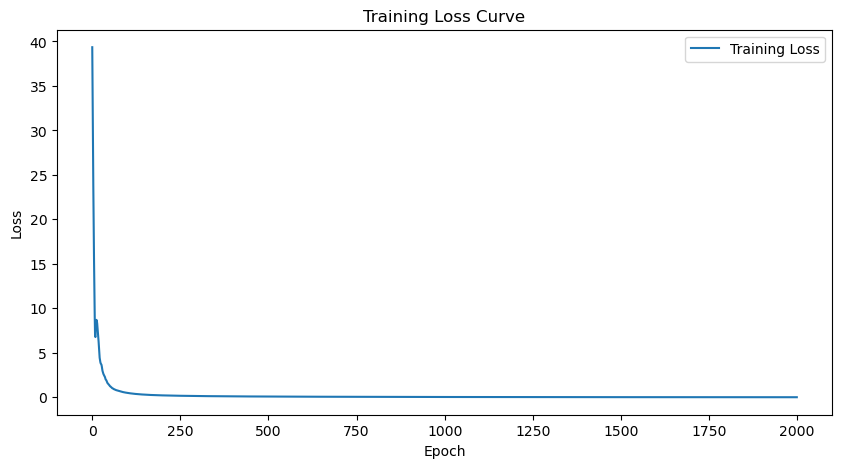

Final Model Accuracy: 64.72%


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token_TSNE2_TSNE3.pth'.


In [11]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.64      0.62      0.63       283
non_infringement       0.65      0.67      0.66       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581



/tmp/ipykernel_2355393/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
